## Aims of this notebook: 
- Plot the LOFAR and Parker Solar Probe dynamic spectra 
- Resample, shift, and combine the spectra together 
- Detect type-III radio bursts and extract their info 
- Mapping the active regions on the Sun corresponding to the radio bursts 
- Calculate the emission intensity profiles of those active regions (e.g. DEM analysis) 
- Interferometric imaging of the sources of radio bursts 
- Explore spatial and temporal correlations between the radio bursts and the observers and among the active phenomena themselves 

### Initialize necessary packages 

In [2]:
import os
import sys
sys.path.insert(1, '../') # make sure to use the code in this repo
import math
import numpy as np
from random import randint
np.random.seed(7)
import glob
import json
import requests
import datetime
import pytz
from spacepy import pycdf
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from matplotlib.pyplot import cm
import pandas as pd
import astropy.io.fits as fits
import scipy
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
myFmt_date = DateFormatter('%Y/%m/%d')
myFmt_time = DateFormatter('%H:%M')
import matplotlib.dates as mdates
from sunpy.coordinates import get_horizons_coord
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_body
from astropy.coordinates import solar_system_ephemeris
#import pytz
#import matplotlib.dates as dates
# try to use the precise epoch 
import matplotlib as mpl
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass
import radioTools_ver2 as rt
import detectRadioburst_ver2 as drb
# import astrospice
import astropy.units as u
import astropy.constants as const
from astropy.time import Time, TimeDelta
from sunpy.coordinates import HeliographicStonyhurst, get_body_heliographic_stonyhurst
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.facecolor'] = 'white'

### Define the date and the directories  

In [3]:
YEAR = '2023'
MONTH = '09'
DAY = '24'
START_TIME_HR = '14'
START_TIME_MIN = '40'
START_TIME_SEC = '00'
END_TIME_HR = '15'
END_TIME_MIN = '10'
END_TIME_SEC = ''
SASID_LBA = 'L2025229'
SASID_HBA = ''

basedir = '/Users/kkozarev/Downloads/lofar_psp'
psp_dir = f'{basedir}/data/'
psp_hfr_dir = f'{basedir}/data/hfr/'
psp_lfr_dir = f'{basedir}/data/lfr/'
solo_dir = f'{basedir}/solo_data/'
lofar_dir = f'{basedir}/LOFAR_data/'
wind_dir = f'{basedir}/Wind_data/'
stereo_dir = f'{basedir}/STEREO_data/'

directories = [psp_dir, psp_hfr_dir, psp_lfr_dir, solo_dir, lofar_dir, wind_dir, stereo_dir]

for direct in directories:
    os.makedirs(direct, exist_ok=True)

--- 

## PSP data 

### LFR 

In [4]:
data_version='v03' #As of 2024/09/25

try:
    URL = f'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/rfs_lfr/{YEAR}/{MONTH}/psp_fld_l2_rfs_lfr_{YEAR}{MONTH}{DAY}_{data_version}.cdf'
    print(URL)
    psp_lfr_filename=f'{psp_lfr_dir}/psp_fld_l2_rfs_lfr_{YEAR}{MONTH}{DAY}_{data_version}.cdf'
    print(psp_lfr_filename)
    response = requests.get(URL)
    open(psp_lfr_filename, 'wb').write(response.content)
except:
     pass

cdf_psp_lfr = pycdf.CDF(psp_lfr_filename)

tmin_lfr = cdf_psp_lfr['epoch_lfr'].meta['SCALEMIN']
tmax_lfr = cdf_psp_lfr['epoch_lfr'].meta['SCALEMAX']

# convert pixels values to dB, # z-axis 
arr_lfr = np.array(cdf_psp_lfr.get('psp_fld_l2_rfs_lfr_auto_averages_ch0_V1V2'))
# the min power scaled power spectral density (PSD) of 1e-16 is used as a threshold according to Pulupa et al. 2020, https://doi.org/10.3847/1538-4365/ab5dc0 
# more info: https://en.wikipedia.org/wiki/Decibel 
Lp_lfr = 10 * np.log10(arr_lfr/10**-16)
# x-axis 
tm_lfr = np.array(cdf_psp_lfr.get('epoch_lfr'))
# y-axis 
freq_lfr = np.array(cdf_psp_lfr.get('frequency_lfr_auto_averages_ch0_V1V2'))[1]/10**6

# clean the dyspec by subtracting the Mean val from each freq channel 
df_psp_lfr = pd.DataFrame(Lp_lfr.T)
df_psp_lfr_mean = df_psp_lfr.mean(axis=1)

# subtract that mean value from each corresponding row 
df_psp_lfr = df_psp_lfr.sub(df_psp_lfr_mean, axis=0)

http://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/rfs_lfr/2023/09/psp_fld_l2_rfs_lfr_20230924_v03.cdf
/Users/kkozarev/Downloads/lofar_psp/data/lfr//psp_fld_l2_rfs_lfr_20230924_v03.cdf


### HFR 

In [5]:
try:
    URL = f'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/rfs_hfr/{YEAR}/{MONTH}/psp_fld_l2_rfs_hfr_{YEAR}{MONTH}{DAY}_{data_version}.cdf'
    print(URL)
    psp_hfr_filename=f'{psp_hfr_dir}/psp_fld_l2_rfs_hfr_{YEAR}{MONTH}{DAY}_{data_version}.cdf'
    print(psp_hfr_filename)
    response = requests.get(URL)
    open(psp_hfr_filename, 'wb').write(response.content)
except:
     pass

cdf_psp_hfr = pycdf.CDF(psp_hfr_filename)

tmin_hfr = cdf_psp_hfr['epoch_hfr'].meta['SCALEMIN']
tmax_hfr = cdf_psp_hfr['epoch_hfr'].meta['SCALEMAX']

# convert pixels values to dB, # z-axis 
arr_hfr = np.array(cdf_psp_hfr.get('psp_fld_l2_rfs_hfr_auto_averages_ch0_V1V2'))
Lp_hfr = 10 * np.log10(arr_hfr/10**-16)
# x-axis 
tm_hfr = np.array(cdf_psp_hfr.get('epoch_hfr'))
# y-axis 
freq_hfr = np.array(cdf_psp_hfr.get('frequency_hfr_auto_averages_ch0_V1V2'))[1]/10**6

# clean the dyspec by subtracting the Mean val from each freq channel 
df_psp_hfr = pd.DataFrame(Lp_hfr.T)
df_psp_hfr_mean = df_psp_hfr.mean(axis=1)

# subtract that mean value from each corresponding row 
df_psp_hfr = df_psp_hfr.sub(df_psp_hfr_mean, axis=0)

http://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/rfs_hfr/2023/09/psp_fld_l2_rfs_hfr_20230924_v03.cdf
/Users/kkozarev/Downloads/lofar_psp/data/hfr//psp_fld_l2_rfs_hfr_20230924_v03.cdf


Plot, after cleaning

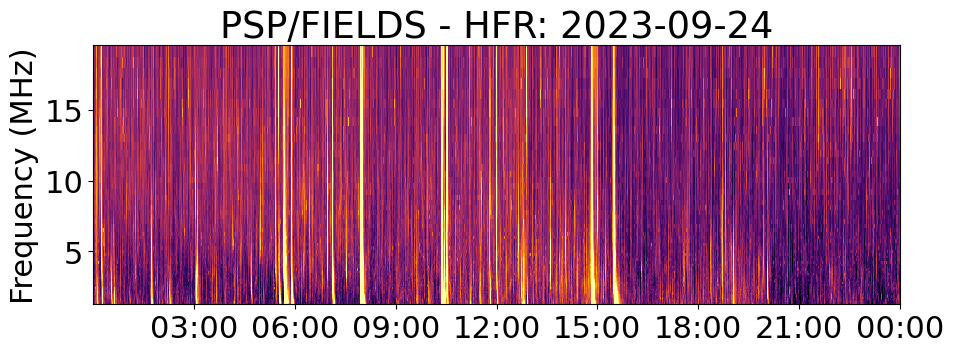

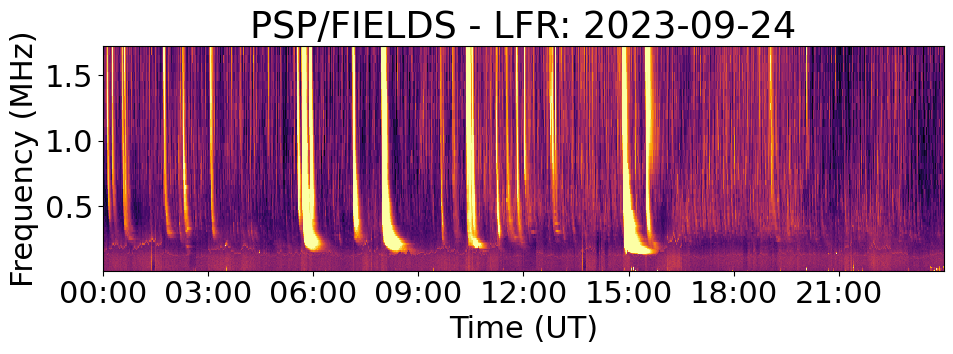

In [6]:
plt.figure(figsize=(10,4))
plt.pcolormesh(tm_hfr, freq_hfr, df_psp_hfr, 
               vmin=(np.nanmean(df_psp_hfr.values)-2 * np.nanstd(df_psp_hfr.values)), 
               vmax=(np.nanmean(df_psp_hfr.values)+3 * np.nanstd(df_psp_hfr.values)), 
               cmap='inferno') # viridis 
plt.ylabel('Frequency (MHz)')
plt.title('PSP/FIELDS - HFR: {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.pcolormesh(tm_lfr, freq_lfr, df_psp_lfr, 
               vmin=(np.nanmean(df_psp_lfr.values)-2 * np.nanstd(df_psp_lfr.values)), 
               vmax=(np.nanmean(df_psp_lfr.values)+3 * np.nanstd(df_psp_lfr.values)), 
               cmap='inferno') # viridis 
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('PSP/FIELDS - LFR: {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()


Concat. the 2 arrays of both bands and plot the combined spectrum

In [7]:
df_lfr = pd.DataFrame(df_psp_lfr)
df_lfr.insert(loc=0, column='frequency', value=freq_lfr)
df_lfr.set_index(['frequency'], inplace=True)

df_hfr = pd.DataFrame(df_psp_hfr)
df_hfr.insert(loc=0, column='frequency', value=freq_hfr)
df_hfr.set_index(['frequency'], inplace=True)
df_psp = pd.concat([df_lfr, df_hfr])
df_psp = df_psp.sort_index(axis=0)

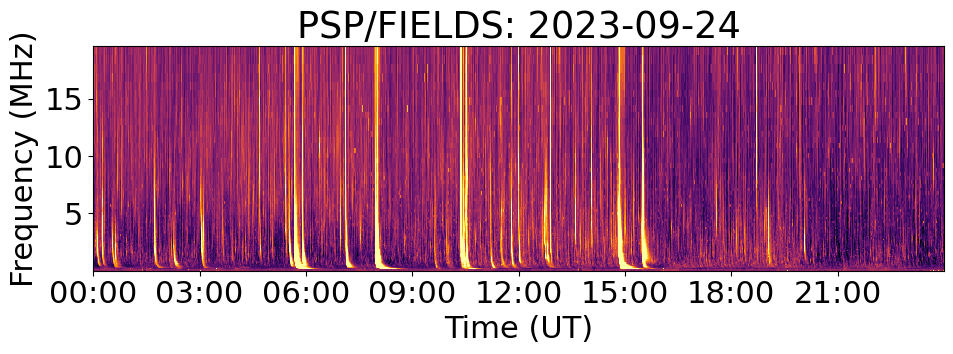

In [8]:
plt.figure(figsize=(10,4))
plt.pcolormesh(tm_lfr, df_psp.index.values, df_psp.values, 
               vmin=np.nanmean(df_psp.values)-2 * np.nanstd(df_psp.values), 
               vmax=np.nanmean(df_psp.values)+3 * np.nanstd(df_psp.values), 
               cmap='inferno')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('PSP/FIELDS: {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
# plt.savefig(basedir+'psp_full_spectrum_{}.png'.format(str(tm_hfr[0].replace(microsecond=0))[:10]))
plt.show()

Plot a normalized spectrum

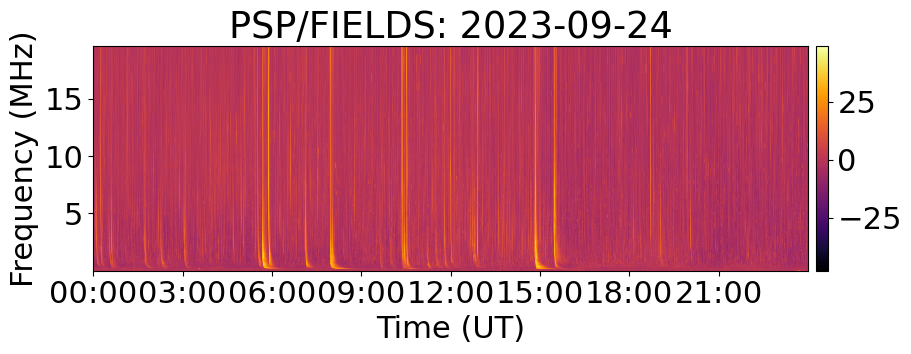

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
img = ax.pcolormesh(tm_lfr, df_psp.index.values, df_psp.values, 
                    norm=colors.CenteredNorm(vcenter=0.5), 
                    cmap='inferno')
fig.colorbar(img, ax=ax, pad=0.01)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title('PSP/FIELDS: {}-{}-{}'.format(YEAR, MONTH, DAY))
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

Plot a specific time range of the spectrum

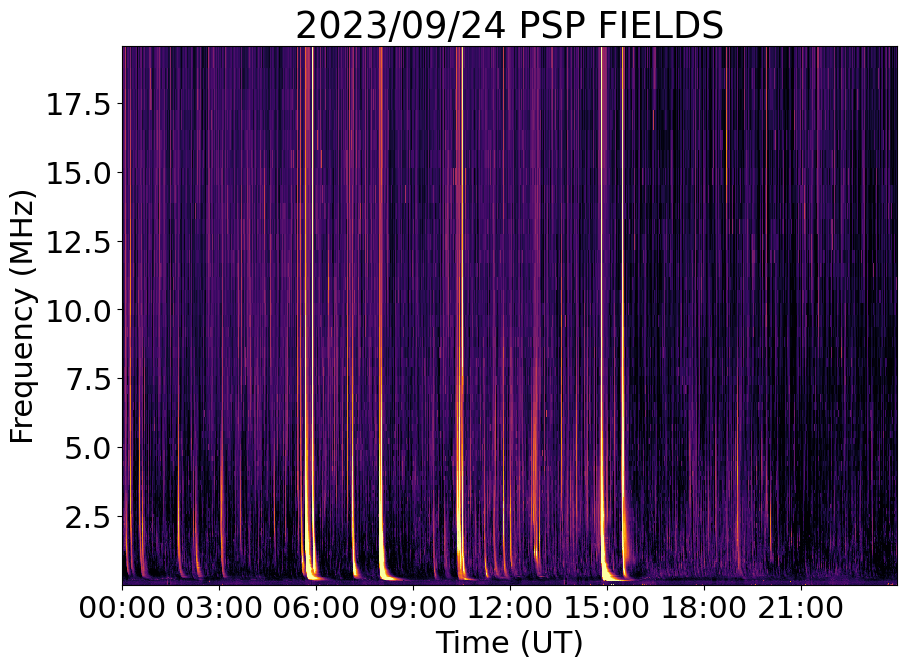

In [10]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
img = ax.pcolormesh(tm_lfr, df_psp.index.values, df_psp.values, 
                    vmin=np.nanmean(df_psp.values)-1 * np.nanstd(df_psp.values), 
                    vmax=np.nanmean(df_psp.values)+5 * np.nanstd(df_psp.values), 
                    cmap='inferno') # ocean, inferno, jet, RdYlBu_r
#fig.colorbar(img, ax=ax, pad=0.01)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f'{YEAR}/{MONTH}/{DAY} PSP FIELDS')
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt_time)
#ax.set_xlim(left=pd.Timestamp(f'{YEAR}/{MONTH}/{DAY} {START_TIME_HR}:{START_TIME_MIN}:{START_TIME_SEC}'), right=pd.Timestamp(f'{YEAR}/{MONTH}/{DAY} {END_TIME_MIN}:{END_TIME_SEC}'))
# plt.savefig(f'{basedir}/plots/psp_dyspec.png', bbox_inches='tight')
#plt.savefig(f'{basedir}/plots/psp_dyspec.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [11]:
print(f'PSP LFR frequency range:\t{freq_lfr[0]*1e3:.2f} kHz -- {freq_lfr[-1]:.2f} MHz')
print(f'PSP HFR frequency range:\t{freq_hfr[0]:.2f} MHz -- {freq_hfr[-1]:.2f} MHz')
print(f'PSP total frequency range:\t{df_psp.index.values[0]*1e3:.2f} kHz -- {df_psp.index.values[-1]:.2f} MHz')

PSP LFR frequency range:	10.55 kHz -- 1.69 MHz
PSP HFR frequency range:	1.27 MHz -- 19.17 MHz
PSP total frequency range:	10.55 kHz -- 19.17 MHz


--- 

## LOFAR 

### LBA 

In [12]:
# import fits files
glob_term=lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_*.fits'.format(YEAR, MONTH, DAY)
print(glob_term)
lofar_LBA_fits = glob.glob(glob_term)
try:
    lofar_LBA_fits.remove(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_LBA_OUTER.fits'.format(YEAR, MONTH, DAY))
except:
    pass
lofar_LBA_fits.sort()
print(lofar_LBA_fits)

# import json files
lofar_LBA_json = glob.glob(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_*.json'.format(YEAR, MONTH, DAY))
try:
    lofar_LBA_json.remove(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_LBA_OUTER.json'.format(YEAR, MONTH, DAY))
except:
    pass
lofar_LBA_json.sort()

# read and store json filex in a list
LBA_json = []
for file in lofar_LBA_json:
    f = open(file)
    LBA_json.append(json.load(f))
    f.close()

/Users/kkozarev/Downloads/lofar_psp/LOFAR_data/L2025229_20230924_LBA/LOFAR_20230924_*.fits
['/Users/kkozarev/Downloads/lofar_psp/LOFAR_data/L2025229_20230924_LBA/LOFAR_20230924_144900_LBA_OUTER_S0.fits']


In [13]:
# read the FREQ axis from one of the fits files
LBA_freq = fits.open(lofar_LBA_fits[0])[1].data['FREQ'][0]

LBA_list = []
for i in range(len(lofar_LBA_fits)):
    # read the fits file 
    tmp = fits.open(lofar_LBA_fits[i])
    df = pd.DataFrame(tmp[0].data)
    # insert the datetimes as index 
    df.insert(loc=0, column='DateTime', value=tmp[1].data['TIME'][0])
    df.set_index(['DateTime'], inplace=True)
    # store the spectra 
    LBA_list.append(df)

# Concat. the list of spectra based on the time index
df_concat_LBA = pd.concat(LBA_list, axis=0)

In [14]:
print(f'LOFAR LBA frequency range:\t{LBA_freq[0]:.2f} MHz -- {LBA_freq[-1]:.2f} MHz')

LOFAR LBA frequency range:	10.49 MHz -- 88.52 MHz


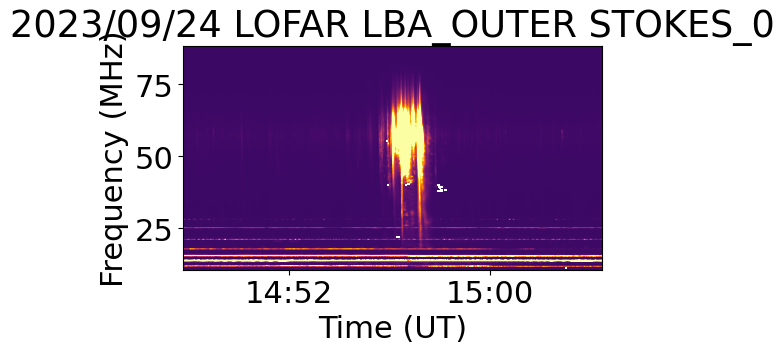

In [15]:
plt.figure(figsize=(6,4), dpi=100)
plt.imshow(df_concat_LBA.values.T, 
            aspect='auto', origin='lower', vmin=(np.nanmean(df_concat_LBA.values)-1 * np.nanstd(df_concat_LBA.values)), 
            vmax=(np.nanmean(df_concat_LBA.values)+3 * np.nanstd(df_concat_LBA.values)),
            extent=[df_concat_LBA.index.values[0], df_concat_LBA.index.values[-1], 
                    LBA_freq[0], LBA_freq[-1]], 
            cmap='inferno')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title(fits.open(lofar_LBA_fits[0])[0].header['CONTENT'])
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

Const. background removal and gaussian smooth

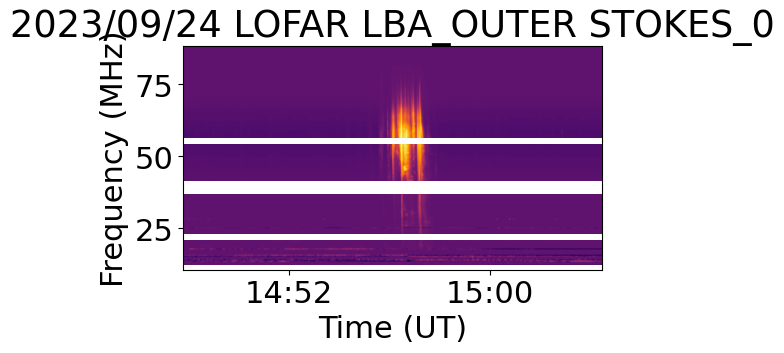

In [16]:
dyspec_lofar_lba = df_concat_LBA.copy()
(lofar_lba_new_tmp, lofar_lba_new) = drb.preproc(dyspec_lofar_lba.values, gauss_sigma=1.5)

plt.figure(figsize=[6,4])
plt.imshow(lofar_lba_new.T, 
            aspect='auto', origin='lower',
            extent=[df_concat_LBA.index.values[0], df_concat_LBA.index.values[-1], 
                    LBA_freq[0], LBA_freq[-1]], 
            cmap='inferno') #RdBu 
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title(fits.open(lofar_LBA_fits[0])[0].header['CONTENT'])
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

--- 

### Define interesting period 

In [17]:
# set the start and end times of interest, assuming we are within the same day 
hh_st, MM_st = int(START_TIME_HR), int(START_TIME_MIN)
hh_et, MM_et = int(END_TIME_HR), int(END_TIME_MIN)

try:
    df_concat_LBA.index = mdates.num2date(df_concat_LBA.index)
except:
    pass

start_pivot = datetime.datetime(int(YEAR), int(MONTH), int(DAY), hh_st, MM_st, tzinfo=df_concat_LBA.index[0].tz)
end_pivot = datetime.datetime(int(YEAR), int(MONTH), int(DAY), hh_et, MM_et, tzinfo=df_concat_LBA.index[0].tz)

In [18]:
def nearest(items, pivot):
    '''
    This function returns the object in 'items' that is the closest to the object 'pivot'.
    '''
    found = min(items, key=lambda x: abs(x - pivot))
    return found

In [19]:
# get the nearest datetimes from LOFAR to the defined times above
st_lof_lba = nearest(df_concat_LBA.index, start_pivot)
et_lof_lba = nearest(df_concat_LBA.index, end_pivot)

# get their indices to be used for slicing the LOFAR data array
st_idx_lofar_lba = np.where(df_concat_LBA.index==st_lof_lba)[0][0]
et_idx_lofar_lba = np.where(df_concat_LBA.index==et_lof_lba)[0][0]

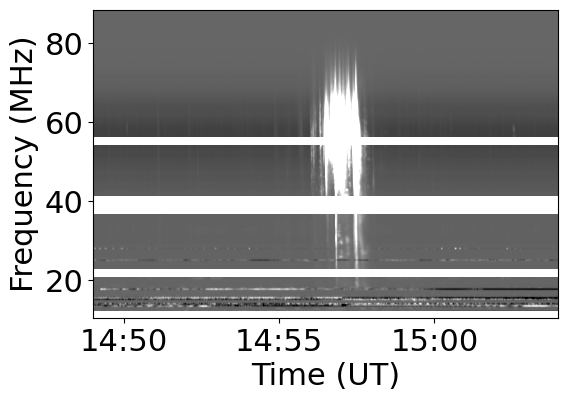

In [20]:
plt.figure(figsize=[6,4])
plt.imshow(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba].T, 
            aspect='auto', origin='lower', 
            vmin=(np.nanmean(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])-2 * np.nanstd(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])), 
            vmax=(np.nanmean(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])+3 * np.nanstd(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])), 
            extent=[mdates.date2num(df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][0]), 
                    mdates.date2num(df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][-1]), 
                    LBA_freq[0], LBA_freq[-1]], 
            cmap='gray') # inferno, RdYlBu_r, gray
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
#plt.title(fits.open(lofar_LBA_fits[0])[0].header['CONTENT'].replace('_', ' '))
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
#fig.savefig(f'{lofar_dir}lofar_LBA_spectrum_{str(tm_hfr[0].replace(microsecond=0))[:10]}.png', format='png', dpi=300, bbox_inches='tight')
#fig.savefig(f'{lofar_dir}lofar_LBA_spectrum_{str(tm_hfr[0].replace(microsecond=0))[:10]}.pdf', format='pdf', bbox_inches='tight')
plt.show()

Plot PSP within the same LOFAR's duration

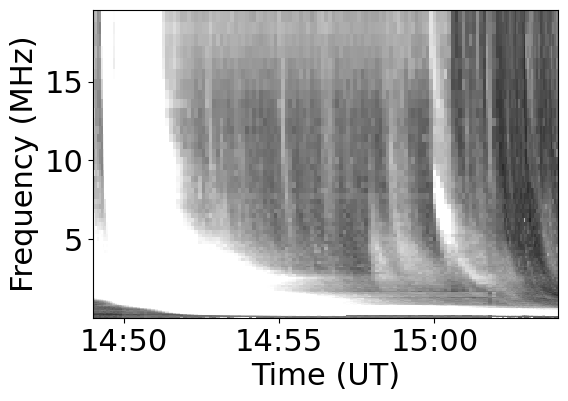

In [21]:
plt.figure(figsize=[6,4])
plt.pcolormesh(tm_lfr, df_psp.index.values, df_psp.values, 
                vmin=np.nanmean(df_psp.values)-2 * np.nanstd(df_psp.values), 
                vmax=np.nanmean(df_psp.values)+3 * np.nanstd(df_psp.values), 
                cmap='gray')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
#plt.title(f'{YEAR}/{MONTH}/{DAY} PSP FIELDS')
plt.xlim(left=df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][0], 
         right=df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][-1])
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
#fig.savefig(f'{psp_dir}psp_full_spectrum_{str(tm_hfr[0].replace(microsecond=0))[:10]}.png', format='png', dpi=300, bbox_inches='tight')
#fig.savefig(f'{psp_dir}psp_full_spectrum_{str(tm_hfr[0].replace(microsecond=0))[:10]}.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [22]:
# set the same time zone as LOFAR for the PSP datetimes too
try:
    tm_lfr = [pytz.timezone('utc').localize(i) for i in tm_lfr]
except:
    pass

# get the nearest datetimes from PSP to the defined times above
st_psp = nearest(tm_lfr, start_pivot)
et_psp = nearest(tm_lfr, end_pivot)

# get their indices to be used for slicing the PSP data array
st_idx_psp = next((i for i, j in enumerate(tm_lfr) if j == st_psp), None)
et_idx_psp = next((i for i, j in enumerate(tm_lfr) if j == et_psp), None)

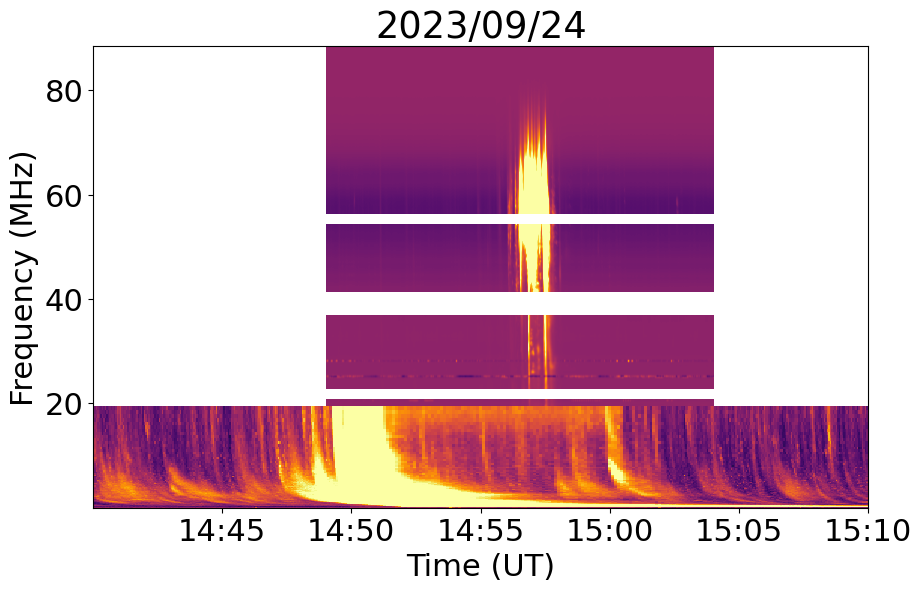

In [23]:
plt.figure(figsize=[10,6])

lf_drange=[(np.nanmean(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])-2 * np.nanstd(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])),
          (np.nanmean(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])+3 * np.nanstd(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba]))]
plt.imshow(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba].T, 
            aspect='auto', origin='lower', 
            vmin=lf_drange[0], 
            vmax=lf_drange[1], 
            extent=[mdates.date2num(df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][0]), 
                    mdates.date2num(df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][-1]), 
                    LBA_freq[0], LBA_freq[-1]], 
            cmap='inferno')

psp_drange=[(np.nanmean(df_psp.values)-2 * np.nanstd(df_psp.values)),(np.nanmean(df_psp.values)+3 * np.nanstd(df_psp.values))]
plt.pcolormesh(tm_lfr, df_psp.index, df_psp.values, 
                vmin=psp_drange[0], 
                vmax=psp_drange[1], 
                cmap='inferno')

plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('{}/{}/{}'.format(YEAR, MONTH, DAY))
plt.xlim(left=st_psp, right=et_psp)
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.show()

### Resampling 

In [24]:
# check cadence
lof_cadence = round((df_concat_LBA.index[1] - df_concat_LBA.index[0]).seconds + (df_concat_LBA.index[1] - df_concat_LBA.index[0]).microseconds/1e6)
lof_cadence = (df_concat_LBA.index[1] - df_concat_LBA.index[0]).seconds + (df_concat_LBA.index[1] - df_concat_LBA.index[0]).microseconds/1e6
print('LOFAR cadence (s):', lof_cadence)

psp_cadence = round((tm_lfr[1] - tm_lfr[0]).seconds + (tm_lfr[1] - tm_lfr[0]).microseconds/1e6)
psp_cadence = (tm_lfr[1] - tm_lfr[0]).seconds + (tm_lfr[1] - tm_lfr[0]).microseconds/1e6
print('PSP cadence (s):', psp_cadence)

# down-sample LOFAR w.r.t. PSP
df_lof_lba = pd.DataFrame(lofar_lba_new)
df_lof_lba.insert(loc=0, column='DateTime', value=df_concat_LBA.index)
df_lof_lba.set_index(['DateTime'], inplace=True)

resamp_lofar_lba = df_lof_lba.resample(str(psp_cadence)+'S').sum()

LOFAR cadence (s): 0.251656
PSP cadence (s): 3.495363


### Calculate the time travel for radio waves to PSP and LOFAR 

In [25]:
# Define the time
t = Time(f'{YEAR}-{MONTH}-{DAY} {START_TIME_HR}:{START_TIME_MIN}:{START_TIME_SEC}')

# Get PSP-Sun distance in AU
psp_sun_distance = get_horizons_coord('PSP', t).radius

# Get Earth-Sun distance in AU
with solar_system_ephemeris.set('builtin'):
    earth = get_body('earth', t)
    sun = get_body('sun', t)

earth_sun_distance = earth.separation_3d(sun)

# convert units to m.
psp_dist   = psp_sun_distance.to(u.m)
earth_dist = earth_sun_distance.to(u.m)

# get the time (seconds) for electromagnetic waves to travel from the Sun to the target (PSP, Earth)
EM_t_travel_psp   = (psp_dist/const.c).value
EM_t_travel_earth = (earth_dist/const.c).value

print(f'\nPSP-Sun distance: {psp_sun_distance:.3f}, radio waves travel time: {EM_t_travel_psp/60:.3f} minutes')
print(f'Earth-Sun distance: {earth_sun_distance:.3f}, radio waves travel time: {EM_t_travel_earth/60:.2f} minutes')
print(f'PSP-Earth distance: {earth_sun_distance-psp_sun_distance:.3f}, radio waves travel time: {(EM_t_travel_earth-EM_t_travel_psp)/60:.2f} minutes')

INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]

PSP-Sun distance: 0.189 AU, radio waves travel time: 1.573 minutes
Earth-Sun distance: 1.003 AU, radio waves travel time: 8.34 minutes
PSP-Earth distance: 0.814 AU, radio waves travel time: 6.77 minutes


### Shifting PSP data to match LOFAR 

In [26]:
psp_struct = pd.DataFrame(df_psp.values.T)
tdiff=(EM_t_travel_earth - EM_t_travel_psp)
psp_shift = psp_struct.copy()
#Shift the times before making them index
psp_shift['DateTime']=pd.Index(tm_lfr) + pd.DateOffset(seconds=tdiff) 
psp_shift.set_index(['DateTime'], inplace=True)

print(f'PSP cadence: {psp_cadence:.2f} seconds')
print(f'Shift time: {(EM_t_travel_earth - EM_t_travel_psp)/60.} minutes')

PSP cadence: 3.50 seconds
Shift time: 6.77062922554451 minutes


In [27]:
print(f'PSP frequency range: {df_psp.index.values[0]*1e3:.2f} kHz - {df_psp.index.values[-1]:.2f} MHz')
print(f'LOFAR LBA frequency range: {LBA_freq[0]:.2f} MHz - {LBA_freq[-1]:.2f} MHz')

PSP frequency range: 10.55 kHz - 19.17 MHz
LOFAR LBA frequency range: 10.49 MHz - 88.52 MHz


Plot after resampling and shifting

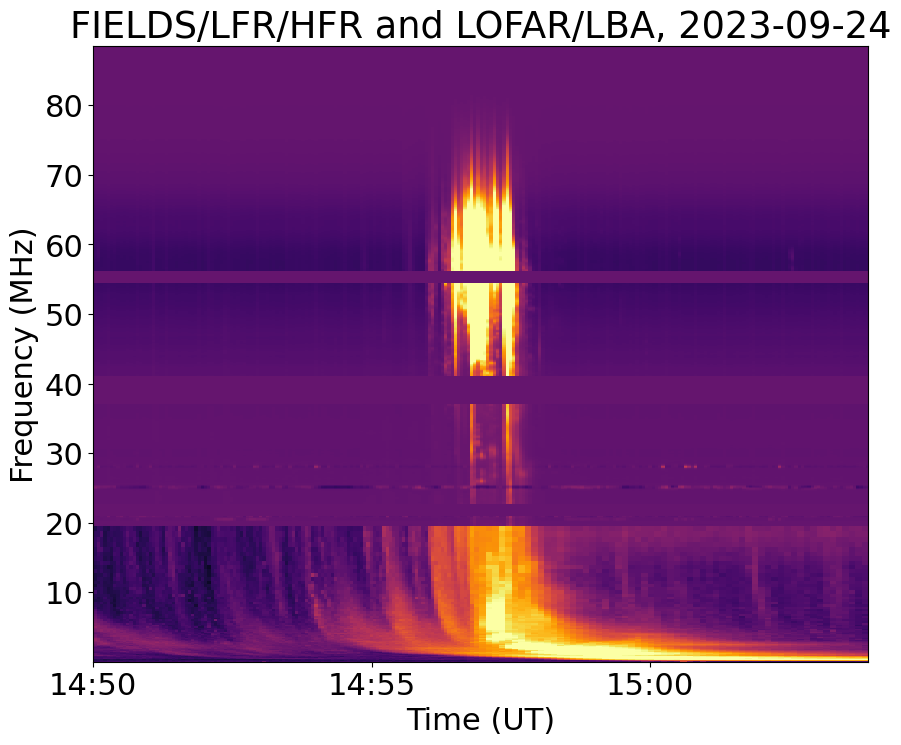

In [39]:
plt.figure(figsize=[10,8])

                
plt.pcolormesh(resamp_lofar_lba.index, LBA_freq, resamp_lofar_lba.T, 
                vmin=(np.nanmean(resamp_lofar_lba.values)-2 * np.nanstd(resamp_lofar_lba.values)), 
                vmax=(np.nanmean(resamp_lofar_lba.values)+5 * np.nanstd(resamp_lofar_lba.values)), 
                cmap='inferno')

# vmin=(np.nanmean(psp_shift.values)-2 * np.nanstd(psp_shift.values)), 
# vmax=(np.nanmean(psp_shift.values)+3 * np.nanstd(psp_shift.values)),
plt.pcolormesh(psp_shift.index, df_psp.index.values, psp_shift.values.T, 
                vmin=(np.nanmean(psp_shift.values)-2 * np.nanstd(psp_shift.values)), 
                vmax=(np.nanmean(psp_shift.values)+8 * np.nanstd(psp_shift.values)),
                cmap='inferno')
 
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('FIELDS/LFR/HFR and LOFAR/LBA, {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.xlim(left=pd.to_datetime('2023/09/24 14:50:00'), right=pd.to_datetime('2023/09/24 15:03:55'))
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.savefig(f'{basedir}/psp_lofar_combined_shifted.png',dpi=200, bbox_inches='tight')


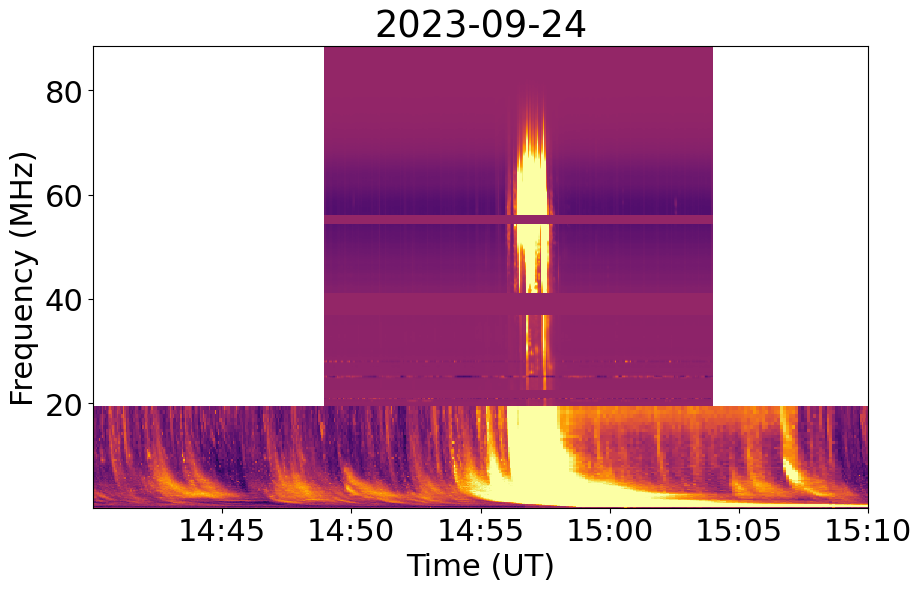

In [30]:
plt.figure(figsize=[10,6])
# plt.figure(figsize=[5,6])

plt.pcolormesh(resamp_lofar_lba.index, LBA_freq, resamp_lofar_lba.T, 
                vmin=(np.nanmean(resamp_lofar_lba.values)-2 * np.nanstd(resamp_lofar_lba.values)), 
                vmax=(np.nanmean(resamp_lofar_lba.values)+3 * np.nanstd(resamp_lofar_lba.values)), 
                cmap='inferno')

plt.pcolormesh(psp_shift.index, df_psp.index.values, psp_shift.values.T, 
                vmin=(np.nanmean(psp_shift.values)-2 * np.nanstd(psp_shift.values)), 
                vmax=(np.nanmean(psp_shift.values)+3 * np.nanstd(psp_shift.values)), 
                cmap='inferno')

plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('{}-{}-{}'.format(YEAR, MONTH, DAY))
plt.xlim(left=st_psp, right=et_psp)
# plt.xlim(left=resamp_lofar_lba.index[0], right=resamp_lofar_lba.index[-1])
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.show()